## Fitting Rb 87

Importing packages

In [34]:
import numpy as np 
from scipy.optimize import curve_fit
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

Importing data and plotting spectrum for 1 file

['I:/Science/Physics-Photonics/Group/Allan_OPM_MEMS_Fab_and_Clocks/PostDoc_Mainly_RbTPT/TPT_signal_data/Infleqtion_wafer/Infleqtion_Phoenix_wafer/Infleqtion_Phoenix_wafer/Abi/InsulationTest/2025-11-19-NoInsulation\\scope_50.csv', 'I:/Science/Physics-Photonics/Group/Allan_OPM_MEMS_Fab_and_Clocks/PostDoc_Mainly_RbTPT/TPT_signal_data/Infleqtion_wafer/Infleqtion_Phoenix_wafer/Infleqtion_Phoenix_wafer/Abi/InsulationTest/2025-11-19-NoInsulation\\scope_51.csv', 'I:/Science/Physics-Photonics/Group/Allan_OPM_MEMS_Fab_and_Clocks/PostDoc_Mainly_RbTPT/TPT_signal_data/Infleqtion_wafer/Infleqtion_Phoenix_wafer/Infleqtion_Phoenix_wafer/Abi/InsulationTest/2025-11-19-NoInsulation\\scope_52.csv', 'I:/Science/Physics-Photonics/Group/Allan_OPM_MEMS_Fab_and_Clocks/PostDoc_Mainly_RbTPT/TPT_signal_data/Infleqtion_wafer/Infleqtion_Phoenix_wafer/Infleqtion_Phoenix_wafer/Abi/InsulationTest/2025-11-19-NoInsulation\\scope_53.csv', 'I:/Science/Physics-Photonics/Group/Allan_OPM_MEMS_Fab_and_Clocks/PostDoc_Mainly_Rb

Text(0, 0.5, 'Residuals / mV')

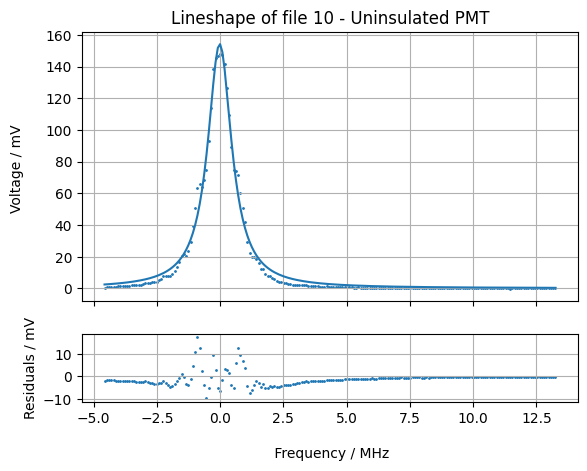

In [35]:
## Location of No Insulation Data
path = 'I:/Science/Physics-Photonics/Group/Allan_OPM_MEMS_Fab_and_Clocks/PostDoc_Mainly_RbTPT/TPT_signal_data/Infleqtion_wafer/Infleqtion_Phoenix_wafer/Infleqtion_Phoenix_wafer/Abi/InsulationTest/2025-11-19-NoInsulation'

## Collect paths of all CSV files from folder into a list
csv_files = glob.glob(os.path.join(path, "*.csv"))
numb_files = len(csv_files) # The number of files

print(csv_files)

fileno = 10

## Take first file and extract data into dataframe
df = pd.read_csv(csv_files[fileno - 1])

## Display data frame
df.head()

## extracting time base (x) and amplitude (y) data
## ommiting column heading
x = (df['x-axis'].to_numpy())[1:] 
y = (df['1'].to_numpy())[1:]

## Converting data to float
x = x.astype(float)
y = y.astype(float)

## Imverting signal
y = np.flip(y)

# Find Peaks - adjusted params to only find 2 peaks
p, properties = find_peaks(y, height = 0.07, distance = 5, prominence = 0.02)

# rescale x and y axes
ptime = np.array([p[0],p[1]])
deltat = x[ptime[1]] - x[ptime[0]]
deltaf = 14.412 #MHz
# zero point is set to centre of largest peak; freq is in MHz
freq = -(x - x[ptime[0]]) * deltaf / deltat

# Get rid of y offset
sig = (y - np.mean(y[0:9]))*1e3 #NB units are mV

## Chop data to focus on biggest peak
sigp = sig[900:1100]
freqp = freq[900:1100]

## Fitting - Loretzian dist.
# 3 params - amplitude A, centre point C, linewidth gamma (FWHM)

def lorentz(xdata,A,C,gamma): 
    x1 = (xdata-C)/(gamma/2)
    return A / (1 + x1**2)


guess = np.array([140,0,2])

popt,pcov = curve_fit(lorentz,freqp,sigp,p0=guess)
perr = np.sqrt(np.diag(pcov))
print(popt, perr)

print('The full width half maximum is {} pm {} Mhz'.format(popt[2],perr[2]))

## Chi Squared

# degrees of freedom = size of dad set - fit params
dof = np.size(freqp) - np.size(popt) 

# chi squared function
def chi_squared(xdata,ydata,f,params):
    return np.sum(((ydata - f(xdata,*params))**2) / f(xdata,*params))

# Calculate cs and reduced cs
cs = chi_squared(freqp,sigp,lorentz,popt)
red_cs = cs / dof
print('The Chi Squared is {}'.format(cs))
print('The Reduced Chi Squared is {}'.format(red_cs))

# Residuals
def residuals(xdata,ydata,f,params):
    return (ydata - f(xdata,*params))

resd = residuals(freqp,sigp,lorentz,popt)

# Plotting
fig, (ax1,ax2) = plt.subplots(2,1, height_ratios = [4,1], sharex='all')

ax1.set_title('Lineshape of file {} - Uninsulated PMT'.format(fileno))
ax1.scatter(freqp,sigp, s = 1)
ax1.plot(freqp,lorentz(freqp,*popt))
ax2.set_xlabel('\n Frequency / MHz')
ax1.set_ylabel('Voltage / mV \n')
ax1.grid(True)
ax2.grid(True)

ax2.scatter(freqp,resd,s=1)
ax2.set_ylabel('Residuals / mV')
